<a href="https://colab.research.google.com/github/FranziskoB/Challenge-Data-Science-Alura-2ed/blob/main/Semana_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio Data Science Alura

A imobiliária InsightPlaces, situada na cidade do Rio de Janeiro, está enfrentando dificuldades para alugar e vender imóveis. Em uma pesquisa de como empresas semelhantes operam no mercado, a InsightPlaces percebeu que esse problema pode estar relacionado aos valores dos imóveis e às recomendações realizadas em seu site.

Dentro desse contexto, como podemos definir de forma eficiente os preços dos imóveis lidando com grandes volumes de dados? É importante recomendar imóveis utilizando outro critério? O que precisa ser feito?

Você faz parte do time de Ciência de Dados e Big Data da InsightPlaces e ficou responsável por auxiliar no processo de análise de dados dos imóveis, que estão localizados em alguns bairros da cidade do Rio de Janeiro.

Esse projeto tem algumas etapas como: ler e fazer o tratamento do histórico dos preços de imóveis no Rio de Janeiro, construir um modelo de regressão para precificar imóveis e, por último, criar um recomendador de imóveis. Para cada uma dessas etapas, vamos utilizar a ferramenta PySpark, que oferece uma melhor performance ao trabalharmos com grandes volumes de dados.

#Semana 3

Criando um modelo de recomendação com PySpark

### Configurando o Spark no Google Colab

In [2]:
# instalar as dependências
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [4]:
import findspark
findspark.init()

#### Acessando o Spark UI (Google Colab)n

Uma SparkSession pode ser utilizada para criar DataFrames, registrar DataFrames como tabelas, executar consultas SQL em tabelas, armazenar em cache e ler arquivos parquet.

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Iniciando com Spark") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

In [6]:
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [7]:
get_ipython().system_raw('./ngrok http 4050 &')

In [8]:
!curl -s http://localhost:4040/api/tunnels

{"tunnels":[],"uri":"/api/tunnels"}


### Carregamento de dados

Descrição de cada variável do dataset
*   id ->	Código de identificação do anúncio no sistema da InsightPlaces
*   tipo_unidade ->	Tipo de imóvel (apartamento, casa e outros)
*   tipo_uso ->	Tipo de uso do imóvel (residencial ou comercial)
*   area_total ->	Área total do imóvel (construção e terreno)
*   area_util ->	Área construída do imóvel
*   quartos ->	Quantidade de quartos do imóvel
*   suites ->	Quantidade de suítes do imóvel
*   banheiros ->	Quantidade de banheiros do imóvel
*   vaga ->	Quantidade de vagas de garagem do imóvel
*   caracteristicas ->	Listagem de características do imóvel
*   andar ->	Número do andar do imóvel
*   endereco ->	Informações sobre o endereço do imóvel
*   valores ->	Informações sobre valores de venda e locação dos imóveis




In [9]:
import zipfile
import requests
from io import BytesIO
import os

In [10]:
os.makedirs("./dados",exist_ok=True) # Criando uma pasta no google colab

In [11]:
path = 'https://github.com/FranziskoB/Challenge-Data-Science-Alura-2ed/raw/main/dados/semana_3_4.zip' # Local do arquivo zip
filebytes = BytesIO(
    requests.get(path).content
)
myzip = zipfile.ZipFile(filebytes)
myzip.extractall("./dados") #Salvando os dados na pasta criada

In [12]:
dados = spark.read.parquet("/content/dados/semana_2") # Importando os dados

In [13]:
dados.count() # Número de registros carregados

66551

### Visualizando os dados

Os primeiro 5 valores


In [14]:
dados.show(5,truncate=False)
dados.printSchema()

+------------------------------------+-----+---------+---------+-------+------+----+---------------+----------+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+------------+----------+----------+--------+
|id                                  |andar|area_util|banheiros|quartos|suites|vaga|bairro         |zona      |condominio|iptu   |valor    |Academia|Animais_permitidos|Churrasqueira|Condominio_fechado|Elevador|Piscina|Playground|Portaria_24h|Portao_eletronico|Salao_festas|Zona_Central|Zona_Norte|Zona_Oeste|Zona_Sul|
+------------------------------------+-----+---------+---------+-------+------+----+---------------+----------+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+------------+----------+----------+--------+
|00790b85-56e3-43a5-a499-9e4c3708b95c|11   |16

## Preparando os dados para a padronização

In [19]:
X = dados.columns
X.remove('zona')
X.remove('bairro')
X.remove('id')
X

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'Academia',
 'Animais_permitidos',
 'Churrasqueira',
 'Condominio_fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria_24h',
 'Portao_eletronico',
 'Salao_festas',
 'Zona_Central',
 'Zona_Norte',
 'Zona_Oeste',
 'Zona_Sul']

In [20]:
from pyspark.ml.feature import VectorAssembler
dados_encoded_vector = VectorAssembler(inputCols=X, outputCol='features').transform(dados) # Criando um vetor com as features
dados_encoded_vector.select('features').show(truncate=False, n=5)

+------------------------------------------------------------------------------------------------------------+
|features                                                                                                    |
+------------------------------------------------------------------------------------------------------------+
|[11.0,166.0,5.0,4.0,4.0,2.0,2100.0,4600.0,1750000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0]|
|(23,[0,1,2,3,4,6,7,8,10,17,22],[4.0,640.0,5.0,11.0,3.0,3060.0,20030.0,3800000.0,1.0,1.0,1.0])               |
|[1.0,50.0,1.0,2.0,0.0,1.0,363.0,97.0,192000.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0]      |
|(23,[1,2,3,4,5,6,7,8,13,22],[160.0,4.0,3.0,1.0,3.0,1530.0,7440.0,3490000.0,1.0,1.0])                        |
|(23,[1,2,3,4,5,8,11,14,15,18,21],[52.0,1.0,2.0,1.0,1.0,440000.0,1.0,1.0,1.0,1.0,1.0])                       |
+------------------------------------------------------------------------------------------------------------+
o

## Construção do recomendador a partir da padronização dos dados

In [21]:
from pyspark.ml.feature import StandardScaler
scaler =StandardScaler(inputCol='features', outputCol='features_scaled_padronizado') #
model_scaler = scaler.fit(dados_encoded_vector)
dados_imoveis_scaler = model_scaler.transform(dados_encoded_vector)

In [22]:
dados_imoveis_scaler.show()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+------------+----------+----------+--------+--------------------+---------------------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|      zona|condominio|   iptu|    valor|Academia|Animais_permitidos|Churrasqueira|Condominio_fechado|Elevador|Piscina|Playground|Portaria_24h|Portao_eletronico|Salao_festas|Zona_Central|Zona_Norte|Zona_Oeste|Zona_Sul|            features|features_scaled_padronizado|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+------------+----------+--

### Redução de dimensionalidade para os dados padronizados

In [25]:
k = len(X)#Número de colunas
k

23

In [26]:
from pyspark.ml.feature import PCA
pca = PCA(k=k, inputCol='features_scaled_padronizado', outputCol='pca_features')
model_pca = pca.fit(dados_imoveis_scaler)
dados_imoveis_pca = model_pca.transform(dados_imoveis_scaler)

In [27]:
sum(model_pca.explainedVariance) * 100

100.0

In [28]:
lista_valores = [sum(model_pca.explainedVariance[0:i+1]) for i in range(k)]
lista_valores

[0.26545749360997906,
 0.43752479497762575,
 0.5287992767783378,
 0.5831729986362509,
 0.6354028103524807,
 0.6820231562211665,
 0.7262890569978809,
 0.767891188168711,
 0.802573009561382,
 0.8297996535128769,
 0.8541943996261356,
 0.8742987112957071,
 0.893509026526103,
 0.9111213166741092,
 0.9266283824349123,
 0.940523160892775,
 0.9525305733295915,
 0.9638657310285278,
 0.9739753651565951,
 0.9832054875066532,
 0.9921039340092809,
 0.999999999999999,
 1.0]

In [29]:
import numpy as np
k = sum(np.array(lista_valores) <= 0.9)#Selecionando o número de componentes que explicam no mínimo 90% da variabilidade dos dados
k

13

In [30]:
pca = PCA(k=k, inputCol='features_scaled_padronizado', outputCol='pca_features')
model_pca = pca.fit(dados_imoveis_scaler)
dados_imoveis_pca = model_pca.transform(dados_imoveis_scaler)

In [31]:
sum(model_pca.explainedVariance) * 100 # Percentual de explicação da variabilidade dos dados

89.3509026526103

###  Aplicação do cluster com K-Means

Definindo o número de clusters pelo método elbow

In [32]:
from pyspark.ml.clustering import KMeans

In [33]:
nmax=100
cost = np.zeros(int(nmax/5))
new_col=np.zeros(int(nmax/5))
df=dados_imoveis_pca
for k in range(2,nmax,5):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('pca_features')
    model = kmeans.fit(df)
    cost[int((k-2)/5)] = model.summary.trainingCost


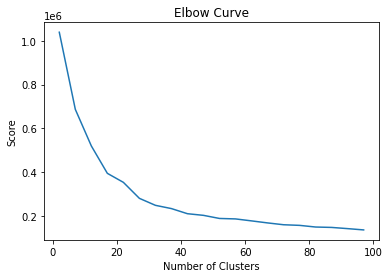

In [34]:
import pandas as pd
df_cost = pd.DataFrame(cost[0:])
df_cost.columns = ["cost"]
new_col = list(range(2,nmax,5))
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

Entre 30 e 40 clusters a curva fica mais horizontal então 35 clusters pode ser uma boa opção

In [35]:
k=35

In [36]:
kmeans = KMeans(featuresCol='pca_features', predictionCol='cluster_pca').setK(k).setSeed(1)

In [37]:
model_kmeans = kmeans.fit(dados_imoveis_pca)

In [38]:
prections_kmeans = model_kmeans.transform(dados_imoveis_pca)

In [39]:
from pyspark.sql import functions as f
prections_kmeans\
    .select('cluster_pca','id', 'quartos', 'area_util', 'banheiros', 'valor', 'Academia', 'Churrasqueira')\
    .groupBy('cluster_pca')\
    .agg(
        f.count("id").alias("Numero_de_imoveis"),
        f.avg("quartos").alias("N_medio_quartos"),
        f.avg("area_util").alias("area_util_media"),
        f.avg("banheiros").alias("N_medio_banheiros"),
        f.avg("valor").alias("valor_medio"),
        (f.avg("Academia")*100).alias("Percentual_de_imoveis_com_academia"),
        (f.avg("Churrasqueira")*100).alias("Percentual_de_imoveis_com_Churrasqueira"),        
    )\
    .orderBy('valor_medio', ascending=True)\
    .show()

+-----------+-----------------+------------------+------------------+------------------+------------------+----------------------------------+---------------------------------------+
|cluster_pca|Numero_de_imoveis|   N_medio_quartos|   area_util_media| N_medio_banheiros|       valor_medio|Percentual_de_imoveis_com_academia|Percentual_de_imoveis_com_Churrasqueira|
+-----------+-----------------+------------------+------------------+------------------+------------------+----------------------------------+---------------------------------------+
|         19|              495|1.3555555555555556| 47.42626262626263|1.1818181818181819| 316031.7696969697|                 8.484848484848486|                      4.848484848484849|
|          5|              648|1.5987654320987654|46.239197530864196|1.1527777777777777|367218.00925925927|                 95.21604938271605|                       81.6358024691358|
|         17|             1191| 2.120067170445004| 73.99412258606213| 1.6389588581024

### Filtrar imóveis do mesmo cluster

filtro para extrair as informações de ID de um imóvel e verificar quais imóveis pertencem ao mesmo cluster.

In [40]:
id='0267dcdb-7705-44ad-b4f5-fa94720aa3cc'# id de exemplo
cluster = prections_kmeans.filter(prections_kmeans.id == id).select('cluster_pca').collect()[0][0]
print("O cluster do imóvel é",cluster)
ids= prections_kmeans.filter(prections_kmeans.cluster_pca == cluster).select('id').collect()
print("\nExemplo de outros imóveis desse mesmo cluster: \n")
for i in ids[0:10]:
  print(i[0])

O cluster do imóvel é 18

Exemplo de outros imóveis desse mesmo cluster: 

0267dcdb-7705-44ad-b4f5-fa94720aa3cc
07bd5c4a-e06d-4dad-b9bb-905752252be1
0a94150e-87e6-4ac5-9cd1-dd5a18b69bfc
1bbd8ced-3b03-4500-99a8-ed249e3df9dc
30f2b01a-1cfe-4bfc-877d-909cc78c36f9
49b3977d-4f01-4d54-a1ec-c66d9bf23b71
4d2a517f-a872-401f-89fb-e2773fca5969
656d034a-100f-4f28-b035-2f8328dbe195
67cc8249-f98f-4b53-8003-90f0b472db67
6917480d-71e4-4321-9b7f-7893ebb57f74


### Construção do recomendador 1

In [41]:
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType

In [108]:
def recomendador_1(id):
  cluster = prections_kmeans.filter(prections_kmeans.id == id).select('cluster_pca').collect()[0][0]
  imoveis_recomendados = prections_kmeans.filter(prections_kmeans.cluster_pca == cluster)
  componenetes_imoveis = imoveis_recomendados.filter(imoveis_recomendados.id == id)\
                                          .select('pca_features').collect()[0][0]

  def calcula_distance(value):
    return euclidean(componenetes_imoveis, value)

  udf_calcula_distance = f.udf(calcula_distance, FloatType())

  imoveis_recomendados_dist = imoveis_recomendados.withColumn('Dist', udf_calcula_distance('pca_features'))

  recomendados = spark.createDataFrame(imoveis_recomendados_dist.sort('Dist').take(10)).drop('features','features_scaled_padronizado','pca_features','cluster_pca')

  recomendados.show(truncate=False)

In [76]:
recomendador_1(id)

+------------------------------------+---------+-------+--------+--------------------+
|id                                  |area_util|quartos|valor   |Dist                |
+------------------------------------+---------+-------+--------+--------------------+
|0267dcdb-7705-44ad-b4f5-fa94720aa3cc|52.0     |2      |440000.0|0.0                 |
|5a9db79f-fb3a-4f5b-ad70-a930f90207af|59.0     |2      |350000.0|0.02921476773917675 |
|12126cc3-23ae-48e9-97f1-8fc7b88371b1|58.0     |2      |398000.0|0.029499942436814308|
|65782c32-8550-44e1-8cad-e82367ca2a40|59.0     |2      |319990.0|0.03238438442349434 |
|c5e9c85a-a547-4d24-a926-a94985910043|59.0     |2      |320000.0|0.03265412524342537 |
|120cb82b-5ea1-45cd-b1ee-19ff0b760d32|60.0     |2      |359000.0|0.03373928368091583 |
|ee41b170-bb91-4bf4-913f-8f4b5a06a196|55.0     |2      |329000.0|0.03612254932522774 |
|c374246b-65c4-4ef1-ab03-ffaf3935ab9a|59.0     |2      |289000.0|0.041100576519966125|
|91cd8cb5-2bbd-40f8-8e0f-4fbc7327ffad|50.0 

##Construção do recomendador a partir da normalização dos dados (Extra)

Aplicando uma forma alternativa da padronização, devido a presença de muitas colunas com valores binários. A normalização deixa todos os dados entre 0 e 1

In [56]:
from pyspark.ml.feature import MinMaxScaler
normal = MinMaxScaler(inputCol='features', outputCol='features_scaled_normal') #
model_normal = normal.fit(dados_encoded_vector)
dados_imoveis_normal = model_normal.transform(dados_encoded_vector)

In [58]:
from pyspark.ml.feature import PCA
k=len(X)
pca = PCA(k=k, inputCol='features_scaled_normal', outputCol='pca_features_norm')
model_pca_norm = pca.fit(dados_imoveis_normal)
dados_imoveis_pca_norm = model_pca_norm .transform(dados_imoveis_normal)

In [61]:
import numpy as np
lista_valores = [sum(model_pca_norm.explainedVariance[0:i+1]) for i in range(k)]
k = sum(np.array(lista_valores) <= 0.9)#Selecionando o número de componentes que explicam no mínimo 90% da variabilidade dos dados
k

7

In [62]:
sum(model_pca.explainedVariance) * 100 # Percentual de explicação da variabilidade dos dados

89.3509026526103

###  Aplicação do cluster com K-Means em dados normalizados

Definindo o número de clusters pelo método elbow

In [ ]:
from pyspark.ml.clustering import KMeans

In [63]:
nmax=100
cost = np.zeros(int(nmax/5))
new_col=np.zeros(int(nmax/5))
df_1=dados_imoveis_pca_norm
for k in range(2,nmax,5):
    kmeans_norm = KMeans().setK(k).setSeed(1).setFeaturesCol('pca_features_norm')
    model = kmeans_norm.fit(df_1)
    cost[int((k-2)/5)] = model.summary.trainingCost


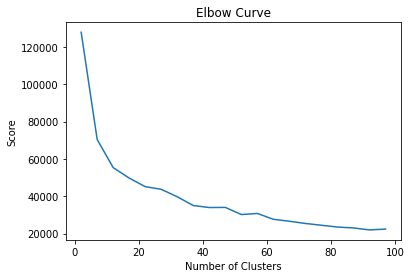

In [64]:
import pandas as pd
df_cost = pd.DataFrame(cost[0:])
df_cost.columns = ["cost"]
new_col = list(range(2,nmax,5))
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [65]:
k=40 # Região onde a curva começa a ficar mais horizontal

In [66]:
kmeans_norm = KMeans(featuresCol='pca_features_norm', predictionCol='cluster_pca_norm').setK(k).setSeed(1)

In [67]:
model_kmeans_norm = kmeans_norm.fit(dados_imoveis_pca_norm)

In [68]:
prections_kmeans_norm = model_kmeans_norm.transform(dados_imoveis_pca_norm)

In [69]:
from pyspark.sql import functions as f
prections_kmeans_norm\
    .select('cluster_pca_norm','id', 'quartos', 'area_util', 'banheiros', 'valor', 'Academia', 'Churrasqueira')\
    .groupBy('cluster_pca_norm')\
    .agg(
        f.count("id").alias("Numero_de_imoveis"),
        f.avg("quartos").alias("N_medio_quartos"),
        f.avg("area_util").alias("area_util_media"),
        f.avg("banheiros").alias("N_medio_banheiros"),
        f.avg("valor").alias("valor_medio"),
        (f.avg("Academia")*100).alias("Percentual_de_imoveis_com_academia"),
        (f.avg("Churrasqueira")*100).alias("Percentual_de_imoveis_com_Churrasqueira"),        
    )\
    .orderBy('valor_medio', ascending=True)\
    .show()

+----------------+-----------------+------------------+------------------+------------------+------------------+----------------------------------+---------------------------------------+
|cluster_pca_norm|Numero_de_imoveis|   N_medio_quartos|   area_util_media| N_medio_banheiros|       valor_medio|Percentual_de_imoveis_com_academia|Percentual_de_imoveis_com_Churrasqueira|
+----------------+-----------------+------------------+------------------+------------------+------------------+----------------------------------+---------------------------------------+
|              24|              267|2.0823970037453186| 57.62921348314607|1.3333333333333333|318746.80149812734|                             100.0|                      80.52434456928839|
|              19|              621| 1.607085346215781|45.971014492753625| 1.146537842190016| 364960.9259259259|                 97.26247987117553|                      83.73590982286635|
|               3|              831| 2.221419975932611| 81.8

### Filtrar imóveis do mesmo cluster

In [70]:
id='0267dcdb-7705-44ad-b4f5-fa94720aa3cc'# id de exemplo
cluster = prections_kmeans_norm.filter(prections_kmeans_norm.id == id).select('cluster_pca_norm').collect()[0][0]
print("O cluster do imóvel é",cluster)
ids= prections_kmeans_norm.filter(prections_kmeans_norm.cluster_pca_norm == cluster).select('id').collect()
print("\nExemplo de outros imóveis desse mesmo cluster: \n")
for i in ids[0:10]:
  print(i[0])

O cluster do imóvel é 8

Exemplo de outros imóveis desse mesmo cluster: 

0267dcdb-7705-44ad-b4f5-fa94720aa3cc
0a94150e-87e6-4ac5-9cd1-dd5a18b69bfc
bac8243e-ffaf-4d46-a530-cec9822cac02
cca0dbb3-7c52-4ed5-8984-f910f2150a5e
0092f04d-ee0a-4965-818a-ee2e58bba23e
17df55d9-33a1-4499-978d-28d55dd72f00
75f6ae14-42e9-4627-9588-7252f3f6be11
9f7ff938-ffbb-42fe-a8ce-cd2bcffc09a5
ea02824c-39c2-4a12-bd94-0d2169a0bce7
05b316ce-f366-4270-b0e2-4e7c579e16b3


### Construção do recomendador 2

In [71]:
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType

In [106]:
def recomendador_2(id):
  cluster = prections_kmeans_norm.filter(prections_kmeans_norm.id == id).select('cluster_pca_norm').collect()[0][0]
  imoveis_recomendados = prections_kmeans_norm.filter(prections_kmeans_norm.cluster_pca_norm == cluster)
  componenetes_imoveis = imoveis_recomendados.filter(imoveis_recomendados.id == id)\
                                          .select('pca_features_norm').collect()[0][0]

  def calcula_distance(value):
    return euclidean(componenetes_imoveis, value)

  udf_calcula_distance = f.udf(calcula_distance, FloatType())

  imoveis_recomendados_dist = imoveis_recomendados.withColumn('Dist', udf_calcula_distance('pca_features_norm'))

  recomendados = spark.createDataFrame(imoveis_recomendados_dist.sort('Dist').take(10)).drop('features','features_scaled_normal','pca_features_norm','cluster_pca_norm')

  recomendados.show(truncate=False)

## Comparação entre os dois recomendadores de imovéis 

In [109]:
print("Recomendador 1")
recomendador_1(id)
print("Recomendador 2")
recomendador_2(id)

Recomendador 1
+------------------------------------+-----+---------+---------+-------+------+----+------------------------+----------+----------+-----+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+------------+----------+----------+--------+--------------------+
|id                                  |andar|area_util|banheiros|quartos|suites|vaga|bairro                  |zona      |condominio|iptu |valor   |Academia|Animais_permitidos|Churrasqueira|Condominio_fechado|Elevador|Piscina|Playground|Portaria_24h|Portao_eletronico|Salao_festas|Zona_Central|Zona_Norte|Zona_Oeste|Zona_Sul|Dist                |
+------------------------------------+-----+---------+---------+-------+------+----+------------------------+----------+----------+-----+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+------------+---

As duas funções retornaram algumas recomendações semelhantes, o segundo recomendador apresentou alguns imoveis com preços mais altos que o recomendador 1 mas pode ser influência do cluster que o imóvel está inserido. Com  a normalização dos dados foi necessário selecionar apenas 7 componetes principais para explicar 90% da variabilidade dos dados, redução de variáveis maior em comparação ao método da padronização que foram necessários 13 componentes para atender ao mesmo requisito. 